# Assignment 3 - Regression

Course "Data processing and Visualization", IE500417, NTNU. Fall 2021

https://www.ntnu.edu/studies/courses/IE500417

**Note: plagiarism is strictly forbidden! You should never copy any source code from other students. If you use any code written by others (except the standards libraries: NumPy, SciPy, Pandas, etc), provide a reference.**

**If the teachers see that your work is mostly copy+paste from online code snippets, the grade can be reduced.**

**If a case of plagiarism is detected, it will be reported to the administration.**

## Task description

In this assignment you will practice regression modelling. We will use a [data set on life expectancy from WHO]. It has been adjusted from the original datasets. The tasks will be to develop different regression models to predict life expectancy of different countries in different years based on their attributes:
1. Simple linear regresion: predict life expectancy with a given adult mortality
2. Calculate residual sum of squares (RSS) to assess model accuracy
3. Compare several polynomial models, find the one with the best RSS
4. Use multiple regression to predict life expectancy based on several features
5. Use Lasso regression to select a subset of features which are relevant for predicting life expectancy
6. Use Lasso regression to select a subset of specific size with most relevant features

## Submission details

The assignment must be handed in on Blackboard. The following must be handed in:
1. Report in PDF or HTML format describing the results of this assignment. Preferably, it is generated from the Jupyter notebook you used (Hint: In Jupyter: File > Download as > HTML). Alternatively (if you use plain Python or other tools), prepare a readable report that contains figures and source code snippets necessary to understand your work.
2. Source code that you used to generate the results. This could be the the Jupyter notebook file, python source files, Matlab files, etc.

Deadlines and grading information on Blackboard.

## Detailed steps

### Step 0: Prepare the data

In [51]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
from sklearn.linear_model import (LinearRegression, Lasso)
import warnings

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [52]:
# Read CSV file from Life-Expectancy-Data
DATA_DIR = Path("../data")
Life_data = pd.read_csv(DATA_DIR / "Life-Expectancy-Data.csv")
print("Number of samples:", len(Life_data))

Number of samples: 2938


In [53]:
Life_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               2938 non-null   int64  
 1   Country                          2938 non-null   object 
 2   Year                             2938 non-null   int64  
 3   Status                           2938 non-null   object 
 4   Life_expectancy                  2938 non-null   float64
 5   Adult_Mortality                  2938 non-null   float64
 6   infant_deaths                    2938 non-null   int64  
 7   Alcohol                          2938 non-null   float64
 8   percentage_expenditure           2938 non-null   float64
 9   Hepatitis_B                      2938 non-null   int64  
 10  Measles                          2938 non-null   int64  
 11  BMI                              2938 non-null   float64
 12  under-five_deaths   

The ID attribute is not useful for processing. GDP and Population data are not complete. So, we remove them from the fields.

In [54]:
Life_data = Life_data.drop(["ID","GDP","Population"], axis="columns")

We will later need three sub-sets of data: training data, validation data (to select best lambda for parametrized models) and test data. We will split the data into these three subsets: 60% for training, 20% for validation, 20% for testing.

We use the DataFrame.sample() function to split the dataset. The `random_state` values are used for reproducibility. All the students should get the same three subsets of data. 

In [55]:
train_data = Life_data.sample(frac=0.6, random_state=12)
valid_and_test = Life_data.drop(train_data.index)
valid_data = valid_and_test.sample(frac=0.5, random_state=62)
test_data = valid_and_test.drop(valid_data.index)

Now we check the statistics for the original data and subsets.

In [56]:
Life_data["Life_expectancy"].describe()

count    2938.000000
mean       69.205412
std         9.530749
min        36.300000
25%        63.025000
50%        72.050000
75%        75.600000
max        89.000000
Name: Life_expectancy, dtype: float64

In [57]:
train_data["Life_expectancy"].describe()

count    1763.000000
mean       69.160976
std         9.521075
min        39.000000
25%        62.950000
50%        72.000000
75%        75.600000
max        89.000000
Name: Life_expectancy, dtype: float64

In [58]:
valid_data["Life_expectancy"].describe()

count    588.000000
mean      69.571939
std        9.366176
min       42.300000
25%       63.800000
50%       72.200000
75%       75.800000
max       89.000000
Name: Life_expectancy, dtype: float64

In [59]:
test_data["Life_expectancy"].describe()

count    587.000000
mean      68.971721
std        9.727240
min       36.300000
25%       63.100000
50%       72.000000
75%       75.400000
max       89.000000
Name: Life_expectancy, dtype: float64

Except the min and max values, Life expectancy are quite ok distributed in the subsets. 

Note: your algorithms should be efficient! For example, when you calculate RSS or create feature matrix (you will see that later), if you do the calculations element-by-element, you will have very slow code. You should use the power of Pandas and Numpy packages and do operations on lists directly. One example: if you want to create a new column called `c` in a dataframe which is a sum of two other columns `a` and `b`, this is a more efficient way:

In [60]:
# dataframe["c"] = dataframe["a"] + dataframe["b"]

This would also work (assuming that rows are indexed by numbers, not timestamps, etc), but will be much slower:

In [61]:
# dataframe["c"] = 0
# for i in range(len(dataframe)):
#    dataframe["c"][i] = dataframe["a"][i] + dataframe["b"][i]

### Step 1: Linear regression

**The task**: create a linear model that predicts life expectancy of a country at a year based on its adult mortality (attribute `Adult_Mortality`). 
Train the model on TRAINING data set!

When you are done, store the intercept and slope (weights w0 and w1) in variables `am_w0` and `am_w1` respectively.

In [62]:
# TODO - your code here
train_X = train_data["Adult_Mortality"].values.reshape(-1, 1)
train_Y = train_data["Life_expectancy"]
reg = LinearRegression().fit(train_X, train_Y)

am_w0 = reg.intercept_
am_w1 = reg.coef_

In [63]:
print("Linear model: life expectancy = %f + %f * Adult_Mortality" % (am_w0, am_w1))

Linear model: life expectancy = 77.774280 + -0.524536 * Adult_Mortality


**Quiz questions**: 
1. Look at the data. How can you interpret the slope coefficient `am_w1`? It will probably be around -0.52. What does it mean?
2. What is the maximum life expectancy for this linear model to make sense?

**--- YOUR ANSWER HERE ---**
1. The slope -0.52 tells us that for every increase in Adult Mortality Rate by 1, we see a 0.52 years decrease in Life Expectancy.
2. The maximum life expectancy for the linear model will be the y intercept which is 77.77428 in this case

Now we can calculate predicted life expectancy and take a look at the regression line. First, we sort the values by mortality, to get a reasonable line in the plot.

In [64]:
train_am_sorted = train_data.sort_values("Adult_Mortality")
predicted_life = am_w0 + am_w1 * train_am_sorted["Adult_Mortality"]

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
# Plot a linear model that predicts life expectancy based on adult mortality
def plot_am_model(amr, predicted_life, observed_life):
    plt.figure(figsize=(5,5))
    plt.plot(amr, observed_life, "c.")
    plt.plot(amr, predicted_life, "k-")
    plt.xlabel("Adult mortality rate")
    plt.ylabel("Life expectancy, years")
    plt.plot()

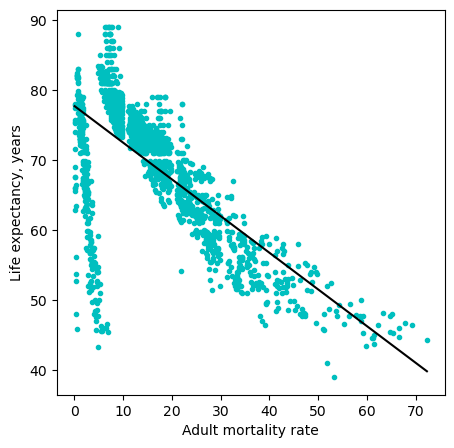

In [67]:
plot_am_model(train_am_sorted["Adult_Mortality"], predicted_life, train_am_sorted["Life_expectancy"])

### Step 2: Calculate residual sum of squares (RSS) to assess model accuracy

One way to estimate error for a given model is to calculate residual sum of squares (RSS). The general formula:

\begin{equation*}
 RSS = \sum_{i=1}^n r_i^2 = \sum_{i=1}^n (y_i - \hat{y}_i)^2
\end{equation*}

Where $r_i$ is the i-th residual, $y_i$ is the i-th observed output, $\hat{y}_i$ is the i-th output predicted by the model. 

In this simple case of linear regression with single input attribute:

\begin{equation*}
 RSS = \sum_{i=1}^n (y_i - (w_0 + w_1 * x_i))^2
\end{equation*}


But before we can calculate RSS, we need to calculate values predicted by our linear model.

**Your task:** Calculated life expectancy predicted by the linear model in the TEST data set. Hint: use "Adult_Mortality" column from `test_data` DataFrame.

In [68]:
# TODO - Your code here
test_X = test_data["Adult_Mortality"].values.reshape(-1, 1)
predicted_test_life = reg.predict(test_X)

**Your task:** Write a function that calculates the residual sum of squares.

In [69]:
# Function that calculates residual sum of squares
# param y: the observer outputs
# param y_hat: the outputs predicted by a model
# return: RSS value, floating point
def rss(y, y_hat):
    return (y_hat - y).pow(2).sum()

Now we can calculate the RSS using test data set.

In [70]:
observed_test_life = test_data["Life_expectancy"]
rss_simple = rss(observed_test_life, predicted_test_life)
print("RSS for our linear model for TEST data: %e" % rss_simple)

RSS for our linear model for TEST data: 2.625196e+04


We can also look at the mean absolute error (MAE):
\begin{equation*}
 MAE = \frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|
\end{equation*}

In [71]:
# Calculate Mean Absolute error based on observed (sampled) and model-predicted life expectancy
# return: a floating point number
def MAE(observed_life, predicted_life):
    n = len(observed_life)
    differences = observed_life - predicted_life
    absolute_differences = differences.abs()
    return absolute_differences.sum() / n
    
mae = MAE(observed_test_life, predicted_test_life)
print("On average, our model predicts life expectancy %.1f years away from the observed value" % mae)

On average, our model predicts life expectancy 4.8 years away from the observed value


Although the error seems to be quite large in absolute numbers, if we look at the life expectancy and linear model chart above, it is not that surprising. The point cloud is wide and the line is indeed not a very accurate representation.

Let us do some unit-testing to check if you got expected results:

In [72]:
assert predicted_test_life.sum() >= 37000
assert predicted_test_life.sum() <= 42000

assert rss_simple >= 2.3e4
assert rss_simple <= 2.8e4

assert mae >= 4
assert mae <= 6

### Step 3: Compare several polynomial models, find the one with the best RSS

In this task we will look at polynomial relationships between adult mortality and life expectancy. To do that, we will create generated features. Feature h1 in the data will be $adult\_mortality$, h2 will be $adult\_mortality^2$, etc. We will prepare a feature matrix that we can use for regression calculations. 

**Task:** First, let's create a function that generates feature matrix containing polynomial with given powers of a single input attribute. For example, if we pass `adult_mortality` samples as input attribute and specify `powers=[1, 3, 4]`, then we should get a matrix with three columns out: $adult\_mortality, adult\_mortality^3, adult\_mortality^4 $.

In [73]:
# A function that takes one input feature and returns a matrix. Each column in the matrix is a power of the input attribute
# param input_attr_col - one column of data, input attribute samples. Either pandas.Series or Numpy array
# param powers - a list (array) containing the desired powers to be created
# 
# Return a DataFrame containing the feature matrix. Use column names h1, h2, h7, etc: hX means 
#  "input attribute to the power X"
def create_feature_matrix(input_attr_col, powers):
    df = pd.DataFrame()
    for power in powers:
        df[f"h{power}"] = np.power(input_attr_col, power)
    return df

Let's create some tests to see if the function works correctly. If the next code block fails to execute, you probably have an error in your `creat_feature_matrix` function.

In [74]:
a = np.array([1, 2, -5])
a1 = create_feature_matrix(a, [1])
a2 = create_feature_matrix(a, [1, 3, 5])
a3 = create_feature_matrix(a, [4, 2])

a1_exp = pd.DataFrame(data = {"h1" : a})
a2_exp = pd.DataFrame(data = {"h1" : a, "h3" : a ** 3, "h5": a ** 5})
a3_exp = pd.DataFrame(data = {"h4" : a ** 4, "h2" : a ** 2})

assert a1_exp.equals(a1)
assert a2_exp.equals(a2)
assert a3_exp.equals(a3)

We can also define a function that will predict outcomes based on input feature matrix and weights found by a model.

In [75]:
def predict(input_features, weights):
    # Prediction is a dot product of feature matrix and weight vector
    return input_features.dot(weights)

For convenience you can use this method to print the polynomial formula that you got:

In [76]:
# Take weights and intercept that the linear regression returned, print the resulting 
# polynomial formula in a (relatively) nice way
# param weights: numpy array of weights w0, w1, w2, ..., wD (coefficients), in increasing order. 
# Note: the intercept is included here as well (as coefficient w0)
def poly_print(weights):
    print(np.poly1d(np.flip(weights, 0)))
    print("")

There is one tricky thing - it is easier to predict outcome if the intercept is also included in the feature matrix as a column with constant 1 as the values. To do that properly, make sure that:
1. When you create feature matrix, include 0 in the `powers` array. It will create a column with ones.
2. When fitting the model, notify the model that it does not have to calculate intercept explicitly. For example, if you use `sklearn.linear_model.LinarRegression.fit()` function, set parameter `fit_intercept=False`.

Now that we have the helper functions, we will create several polynomial regression models and find the best one. The degree of the polynomial is a parameter for our model. Therefore we will use the VALIDATION set when calculating, which polynomial gives the most accurate result. When we have found the best polynomial, we will evaluate its accuracy on the TEST data set.

**Task for you now**.
Variable `max_power` will iterate from 1 to 20. For each `max_power` value:
1. Generate feature matrix that contains the mortality rate of training data (`Adult_Mortality` column) polynomial with all powers from 1 to `max_power`. For example, if `max_power == 3`, you should have a feature matrix containing \[constant 1, $Adult\_Mortality$, $Adult\_Mortality^2$ and $Adult\_Mortality^3$\].
2. Fit a linear model using the feature matrix as input and life expectancy as predictable output. Hint: use [`sklearn.linear_model.LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
3. Predict output by the model on VALIDATION set. Hint: you need to generate a new feature matrix for the validation set.
4. Calculate RSS for the model on VALIDATION set.
5. Compare it with the best RSS found so far. If this RSS is better, save this model as the best one.

At the end of this procedure, save information about the best model:
1. Store minimum RSS in variable `best_rss`.
2. Store best polynomial degree (power) in variable `best_max_power`.
3. Store weights (coefficients) found by the model in variable `poly_weights`.
4. Calculate RSS for the best polynomial model on TEST data. Store it in variable `best_poly_rss`.

Then plot the observed samples and regression curve. Hint: for a better plot you may want to generate a list of increasing mortality values: from 0 to 70, with step 0.1 ([`numpy.arange()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html) function may be handy). Then generate a feature matrix from it and predict life expectancy based on your model. Then plot the life expectancy VS adult mortality.

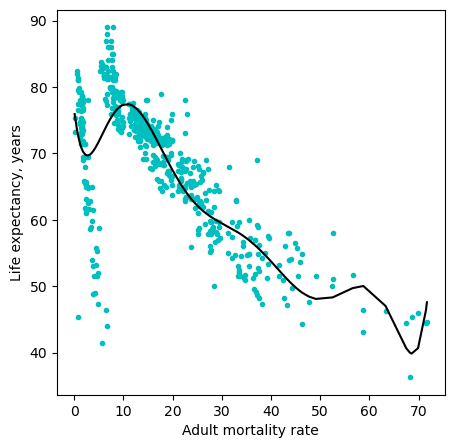

In [77]:
best_rss = None
best_max_power = None
poly_weights = None

train_Y = train_data["Life_expectancy"]
val_Y = valid_data["Life_expectancy"]
test_Y = test_data["Life_expectancy"]

for max_power in range(1, 21):
    power_array = [i for i in range(0, max_power + 1)]
    train_X = create_feature_matrix(train_data["Adult_Mortality"], power_array)
    
    reg = LinearRegression(fit_intercept=False).fit(train_X, train_Y)
    
    val_X = create_feature_matrix(valid_data["Adult_Mortality"], power_array)
    predictions = predict(val_X, reg.coef_)
    
    rss_calculated = rss(val_Y, predictions)
    
    if best_rss is None or rss_calculated < best_rss:
        best_rss = rss_calculated
        best_max_power = max_power
        poly_weights = reg.coef_

# Plotting on test data
power_array = [i for i in range(0, best_max_power + 1)]
test_sorted = test_data.sort_values("Adult_Mortality")
test_X_sorted = create_feature_matrix(test_sorted["Adult_Mortality"], power_array)
predictions = predict(test_X_sorted, poly_weights)
plot_am_model(test_sorted["Adult_Mortality"], predictions, test_sorted["Life_expectancy"])

best_poly_rss = rss(test_sorted["Life_expectancy"], predictions)

In [78]:
print("Best model found for polynomial with degree %i" % (best_max_power))
print("It has RSS for TEST data: %e" % (best_poly_rss))
print("The polynomial:")
poly_print(poly_weights)

Best model found for polynomial with degree 8
It has RSS for TEST data: 1.882467e+04
The polynomial:
           8             7             6             5            4
1.347e-10 x - 3.872e-08 x + 4.552e-06 x - 0.0002814 x + 0.009761 x
           3         2
 - 0.1862 x + 1.737 x - 6.033 x + 76.51



Let's run some unit tests to see if your answer is according to the expectation:

In [79]:
assert best_max_power == 8

assert poly_weights[0] >= 76
assert poly_weights[0] <= 77
assert poly_weights[1] >= -7
assert poly_weights[1] <= -6
assert poly_weights[2] >= 1.7
assert poly_weights[2] <= 1.8
assert poly_weights[3] >= -0.19
assert poly_weights[3] <= -0.18
assert poly_weights[4] >= 0.009
assert poly_weights[4] <= 0.01

assert best_poly_rss >= 1.8e4
assert best_poly_rss <= 1.9e4

print ("All tests passed, the calculations are correct!")

All tests passed, the calculations are correct!


### Step 4: Use multiple regression to predict life expectancy based on several features

In this part you will predict life expectancy based on several attributes. 

**Do the following**:
1. Create a linear model of predicting life expectancy based on adult mortality and infant deaths (`Adult_Mortality` and `infant_deaths` columns). Fit the model on TRAINING data.
2. Calculate RSS for this model on VALIDATION data, store it in variable `adult_infant_rss`.
3. Create another model: use attributes `Adult_Mortality`, `infant_deaths` and `BMI`. Fit it on TRAINING data.
4. Calculate RSS for this model on VALIATION data, store it in variable `adult_infant_bmi_rss`.
5. Compare the accuracy (RSS values) of the two models. Which one provides higher accuracy on average?
6. There is a country in a certain year in the validation data with adult mortality 9.2, infant deaths 231, and attribute `BMI` is 28.1, life expectancy: 75.0 years old. What life expectancy do your two models predict for this country? Which model's predicted life expectancy is closer to the ground truth value (75.0)?
7. Calculate RSS of the best model on TEST data. Store it in variable `best_multi_rss`.

In [80]:
# Let's get the reference life expectancy
LE_75 = Life_data[(Life_data["Adult_Mortality"] == 9.2) & (Life_data["infant_deaths"] == 231) & (Life_data["BMI"] == 28.1)]
print("Reference Life: ")
LE_75

Reference Life: 


,Country,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under-five_deaths,Polio,Total_expenditure,Diphtheria,HIV/AIDS,thinness_1-19_years,thinness_5-9 years,Income_composition_of_resources,Schooling
565,China,2010,Developing,75.0,9.2,231,5.75,5.660755,99,38159,28.1,268,99,4.89,99,0.1,4.2,3.6,0.691,12.5


In [81]:
feature_set_1 = ["Adult_Mortality", "infant_deaths"]
feature_set_2 = ["Adult_Mortality", "infant_deaths", "BMI"]
train_Y = train_data["Life_expectancy"]
val_Y = valid_data["Life_expectancy"]
test_Y = test_data["Life_expectancy"]

# Training on feature set 1
train_X = train_data[feature_set_1]
reg1 = LinearRegression(fit_intercept=True).fit(train_X, train_Y)

# Validation RSS on feature set 1
val_X = valid_data[feature_set_1]
predictions = reg1.predict(val_X)
adult_infant_rss = rss(val_Y, predictions)

# Training on feature set 2
train_X = train_data[feature_set_2]
reg2 = LinearRegression(fit_intercept=True).fit(train_X, train_Y)

# Validation RSS on feature set 2
val_X = valid_data[feature_set_2]
predictions = reg2.predict(val_X)
adult_infant_bmi_rss = rss(val_Y, predictions)

print(f"RSS feature set 1: {adult_infant_rss} \nRSS feature set 2: {adult_infant_bmi_rss}")
print("* ------------- * ------------- *")
print(f"Prediction using feature set 1: {reg1.predict(LE_75[feature_set_1])[0]} \nPrediction using feature set 2: {reg2.predict(LE_75[feature_set_2])[0]}")

# Computing RSS for test data
best_feature_set = None
best_coef = None
if adult_infant_rss < adult_infant_bmi_rss:
    best_feature_set = feature_set_1
    best_coef = reg1.coef_
else:
    best_feature_set = feature_set_2
    best_coef = reg2.coef_

test_X = test_data[best_feature_set]
best_multi_rss = rss(test_Y, predict(test_X, best_coef))

RSS feature set 1: 25929.63324223521 
RSS feature set 2: 20954.60024278272
* ------------- * ------------- *
Prediction using feature set 1: 71.04223880588732 
Prediction using feature set 2: 69.7570987342817


**--- YOUR ANSWER HERE ---**

1. As shown above, feature set 2 - `["Adult_Mortality", "infant_deaths", "BMI"]` has a lower RSS and hence better accuracy on an average
2. As shown above, the predicted life expectancy using feature set 1 is `71.042` while that using feature set 2 is `69.757`. Thus feature set 2 is closer to the ground truth.

In [82]:
print("RSS for the best multi-attribute model on the TEST data: %e" % (best_multi_rss))

RSS for the best multi-attribute model on the TEST data: 2.926565e+06


### Step 5: Use Lasso regression to select a subset of features which are relevant for predicting life expectancy

In this step you will start with a long list of features, and try to eliminate non-relevant ones by using Lasso regression. You will try different lambdas, find the best lambda value.

First we define the starting set of features to use in our model.

In [83]:
all_features = ['Year',
                'Adult_Mortality', 
                'infant_deaths',
                'Alcohol', 'percentage_expenditure', 'Hepatitis_B', 
                'Measles', 'BMI', 'under-five_deaths',
                'Polio', 'Total_expenditure',
               'Diphtheria','HIV/AIDS','thinness_1-19_years','thinness_5-9 years',
                'Income_composition_of_resources', 'Schooling']

train_data_all = train_data[all_features]

**A warm-up task**: create a Lasso model with lambda=0.1 (set parameter `alpha=0.1` for the sklearn Lasso model).
To make the iterative calculation converge, use parameters `normalize=True` and `max_iter=100000` for the Lasso model.

Fit the model on training data, then evaluate RSS on VALIDATION data. Store the RSS in variable `lasso_warmup_rss`.

In [84]:
# TODO - your code here

# Training
train_X = train_data_all
train_Y = train_data["Life_expectancy"]
val_X = valid_data[all_features]
val_Y = valid_data["Life_expectancy"]
reg = Lasso(alpha=0.1, normalize=True, max_iter=100000).fit(train_X, train_Y)
predictions = reg.predict(val_X)
lasso_warmup_rss = rss(val_Y, predictions)

print(lasso_warmup_rss)

26768.214303990055


**Next task:** Find which attributes have non-zero weights, print out their names and weights. Hint: create a function `print_nonzero_weights`, you will need it later.

In [85]:
# TODO - your code here
def print_nonzero_weights(attributes, coef):
    for idx in range(0, len(coef)):
        if(coef[idx] != 0):
            print(f"{attributes[idx]}: {coef[idx]}")

print_nonzero_weights(all_features, reg.coef_)

Adult_Mortality: -0.0982757025527663
Schooling: 0.7122237664767337


Now you will find the best lambda parameter for this model. 

**Do the following**:
* Iterate over lambda values from 0.1 to 10000 (use the `penalties` array, already given, see below). For each lambda:
  * Train a Lasso model, using the given input features (`train_data_all`). Set `alpha` parameter to your lambda value,  and `normalize=True` to penalize all attributes equally. Remember parameter `max_iter=100000`.
  * Calculate RSS for the model on VALIDATION data set.
* Find out which lambda had the lowest RSS value, store it as variable `best_lambda`.
* Print the non-zero weights for this model. Print also the intercept.

Hint: do not use `lambda` as variable name, it is a reserved keyword in Python!

Hint #2: Don't be surprised that the best model will probably be with the lowest lambda. It just shows that leaving out certain features would not give a more accurate model.

**Reflection question:** Which of the 17 initial parameters was "discarded" by the Lasso regression as an insignificant attribute?

**--- YOUR ANSWER HERE ---**  
When we get the least value of rss, ie. best possible value of lambda, the model considers all attributes to be insignificant. 

In [86]:
penalties = np.logspace(-4, 3, num=30)
best_lambda = None
lowest_lasso_rss = None
excluded_features = None
intercept = None
best_lasso_model = None

train_X = train_data_all
val_X = valid_data[all_features]
train_Y = train_data["Life_expectancy"]
val_Y = valid_data["Life_expectancy"]

for l in penalties:
    reg = Lasso(alpha=l, normalize=True, max_iter=100000).fit(train_X, train_Y)
    predictions = reg.predict(val_X)
    rss_computed = rss(val_Y, predictions)
    
    if lowest_lasso_rss == None or rss_computed < lowest_lasso_rss:
        lowest_lasso_rss = rss_computed
        best_lambda = l
        best_lasso_model = reg
    break
        
# Printing non-zero coefs for attributes
print_nonzero_weights(all_features, best_lasso_model.coef_)

Year: -0.022939597314719853
Adult_Mortality: -0.17712146317165806
infant_deaths: 0.08617139893360873
Alcohol: 0.08684854783971607
percentage_expenditure: 0.0004517363720859095
Hepatitis_B: -0.004537165525022533
Measles: -2.2046941302913923e-05
BMI: 0.039181700879840235
under-five_deaths: -0.06411971901305817
Polio: 0.0323664806909687
Total_expenditure: -0.0674415255110097
Diphtheria: 0.030340758683275317
HIV/AIDS: -0.5155996814396291
thinness_1-19_years: -0.04797008905968007
thinness_5-9 years: 0.004143785456149918
Income_composition_of_resources: 0.778783819548255
Schooling: 1.0434005980406502


In [87]:
# The best lambda should be 0.0001
assert best_lambda == 0.0001

### Step 6: Additional Lasso challenge

Sometimes you may want to select a limited number of attributes that predict the output reasonably well. 

**The task** in this step is to find a lambda such that the **number of non-zero weights is reduced to three**. You should try to get the lambda as small as possible, but don't go too far, it is ok to have a lambda that is reasonably close to the minimal possible. 

Hint: you will probably get the lambda around 0.0535.

Fit a model using Lasso regression and `train_data_all` features.

Print the names of attributes having non-zero weights, and print the weights as well.

In [91]:
# TODO - your code here
def count_num_nonzero(coefs):
    count = 0
    for coef in coefs:
        count += 1 if coef != 0 else 0
    return count

train_X = train_data_all
train_Y = train_data["Life_expectancy"]
val_X = valid_data[all_features]
val_Y = valid_data["Life_expectancy"]

resolution = 1000
start_l = 0.1
end_l = 0.01
range_l = np.linspace(start_l, end_l, resolution, endpoint=True) 

best_model = None
lowest_rss = None
lowest_l = None

for l in range_l:
    reg = Lasso(alpha=l, normalize=True, max_iter=100000).fit(train_X, train_Y)
    if count_num_nonzero(reg.coef_) > 3:
        break
        
    predictions = reg.predict(val_X)
    rss_computed = rss(val_Y, predictions)
    if lowest_rss == None or lowest_rss > rss_computed:
        lowest_l = l
        lowest_rss = rss_computed
        best_model = reg
    
print_nonzero_weights(all_features, best_model.coef_)
print("* ------------- * ------------- *")
print(f"Lambda: {lowest_l}")

Adult_Mortality: -0.1503902662521469
HIV/AIDS: -0.24563580963736445
Schooling: 1.1134814207357722
* ------------- * ------------- *
Lambda: 0.053603603603603604


## Reflection 

Please reflect on the following questions:
1. How did the assignment go? Was it easy or hard?  
A. It was slightly challenging.

2. How many hours did you spend on it?  
A. 3.5hrs

3. What materials did you use to study the concepts necessary for the assignment?  
A. I just went through your slides and looked up the internet whenever needed.

## Hints

1. package `sklearn.linear_model` has all the functions you need to create [linear regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [Ridge regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) and [Lasso regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). Parameter lambda is called `alpha` in this package.
2. For a simple linear regression with one input attribute, it is easier to use [`scipy.stats.linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) function.